# Halo model power spectra
This example illustrates how to use CCL to calculate power spectra using the halo model.

This notebook has to be run with `desc-python` kernel!!!

In [1]:
import sys
sys.path.append('/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/scripts/')
import HSCAnalysisUtils
import HSCMeasurementUtils as hmu

In [38]:
# Working kernel: desc-python !!!!!!!!!!!!!!!!!!!!!
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm
from scipy.special import erf
# %matplotlib inline
import os 
import sacc
import datetime
import time

%matplotlib inline
colors = ['#000000', '#800080', '#008000', '#ff0000', "#E69F00", "#56B4E9", "#009E73", "#F0E442", '#800080', "#0072B2", "#CC79A7", "#D55E00", '#0000ff', '#ffa500', '#00ffff', '#800000', '#008080', '#808000', '#ff00ff', '#00ff00']

## Preliminaries
Generate a cosmology object and a couple of $k$ (comoving wavenumber) and $a$ (scale factor) arrays.

Planck cosmology 
$\Omega_{CDM} = 0.264$, $\Omega_b = 0.0493$, $h=0.6736$, $\sigma_8 = 0.8111$ and $n_s = 0.9649$

In [3]:
# Planck 2018 Cosmology
cosmo = ccl.Cosmology(Omega_c=0.264, Omega_b=0.0493, h=0.6736, sigma8=0.8111, n_s=0.9649)

# Wavenumbers and scale factors
k_arr = np.geomspace(1E-4,1E1,256)
a_arr = np.linspace(0.1,1,64)

In [4]:
# Compute As for the given cosmology
cosmo.cosmo.params

<pyccl.ccllib.parameters; proxy of <Swig Object of type 'struct ccl_parameters *' at 0x7f16fea567f0> >

Let us also initialize a series of halo model quantities. We will need:
- A halo mass definition.
- A concentration-mass relation.
- A halo mass function parametrization.
- A halo bias parametrization.
- Halo profiles corresponding to the quantities we want to compute the power spectrum of.

In [5]:
# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()

# The Duffy 2008 concentration-mass relation (Checked - used in paper)
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# The Tinker 2008 mass function (Checked - used in paper)
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200m)

# # The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

Additionally, in order to showcase the flexibility of the current halo model implementation, let us create our own halo profile characterizing the galaxy overdensity using a Halo Occupation Distribution model. We will use the same parametrization used in Nicola et al. https://arxiv.org/abs/1912.08209.

In [6]:
pg = HSCAnalysisUtils.HaloProfileHOD(cM)

## Halo model power spectra

The halo-model power spectrum for two quantities defined by their halo profiles $u$ and $v$ is given by
\begin{equation}
   P_{uv}(k) = \int dM\,n(M)\,\langle u(k|M)\,v(k|M)\rangle + \left[\int dM\,n(M)\,b(M)\,\langle u(k|M)\rangle\right]\,\left[\int dM\,n(M)\,b(M)\,\langle v(k|M)\rangle\right]\,P_{\rm lin}(k).
\end{equation}

The first part, the so-called "one-halo" term, involves the Fourier-space two-point cumulant of the two profiles ($\langle u(k|M)\,v(k|M)\rangle$). This is often approximated by the product of the profile means ($\langle u(k|M)\rangle\,\langle v(k|M)\rangle$), but this is not correct in general (e.g. for the HOD profile). For this reason, the computation of the halo model power spectrum in CCL requires three main ingredients:
- The two profiles to be correlated.
- The linear matter power spectrum. Together with the profile means it controls the 2-halo term.
- The two-point cumulant of the two profiles, controlling the 1-halo term. By default we will set this to the product of the profile means, but we provide ways to define your own two-points.

Let's start by computing the different auto- and cross-correlations between matter and galaxy overdensities at $z=0$.

The first step is creating a `HMCalculator` object that essentially takes care of the mass integrals.

In [7]:
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m)

Now let's start computing the different power spectra. Note that, because we are interested in overdensities, we normalize by the means of both quantities. This is done by setting the `normprof` parameters of all method calls to `True`.

### 1. Matter-matter

In [8]:
pk_MM = ccl.halos.halomod_power_spectrum(cosmo, 
                                         hmc,
                                         k_arr,
                                         1.,
                                         pM,
                                         normprof1=True)

### 2. Galaxy-matter

In [9]:
pk_gM = ccl.halos.halomod_power_spectrum(cosmo = cosmo,
                                         hmc = hmc,
                                         k = k_arr,
                                         a = 1.,
                                         prof = pg,
                                         prof2 = pM,
                                         normprof1 = True,
                                         normprof2 = True)

### 3. Galaxy-galaxy

In this case we have a non-trivial two-point cumulant (see Eq. 3.9 of https://arxiv.org/abs/1909.09102). To deal with this we first create a `ProfileCovar` object that implements this.

In [10]:
HOD2pt = HSCAnalysisUtils.Profile2ptHOD()
    
pk_gg = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1.,
                                         pg, prof_2pt=HOD2pt,
                                         normprof1=True)

OK, great, now let's plot the power spectra!

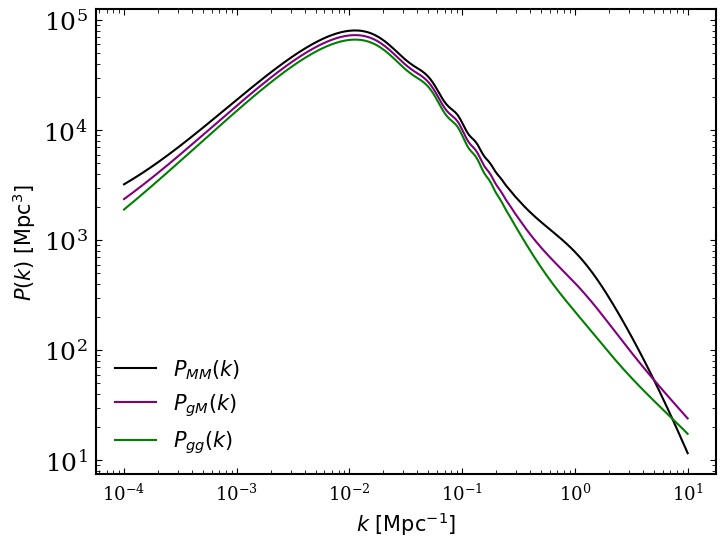

In [11]:
plt.figure()
plt.plot(k_arr, pk_MM, colors[0], label='$P_{MM}(k)$')
plt.plot(k_arr, pk_gM, colors[1], label='$P_{gM}(k)$')
plt.plot(k_arr, pk_gg, colors[2], label='$P_{gg}(k)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', frameon=False, fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^3]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)

plt.show()
plt.close()

## 2D power spectra and $C_\ell$ s

The `HMCalculator` objects can also provide `Pk2D` power spectrum objects that can then be used to perform Limber integrals and compute angular power spectra. Let's do so for the 3D cross correlations we just looked at.

First, let's create two CCL tracers, a `NumberCountsTracer` that we will associate with the galaxy overdensity, and a `WeakLensing` tracer that we will associate with the matter overdensity.

Here we read the redshift distribution of the lens galaxy sample, similar to the one used in the galaxy clustering analysis presented in Nicola et al.

In [12]:
pk_ggf = ccl.halos.halomod_Pk2D(cosmo,
                                hmc,
                                pg,
                                prof_2pt=HOD2pt,
                                normprof1=True,
                                lk_arr=np.log(k_arr),
                                a_arr=a_arr)

# Save into a data-vector
Put this auto- and cross- correlations of the galaxy clustering in a Firecrown readable format.

Mimicking the sacc file generation process in https://github.com/LSSTDESC/sacc/blob/master/examples/Create_Sacc.ipynb

Adding lens dndz z-bin 1 ...
Adding lens dndz z-bin 2 ...
Adding lens dndz z-bin 3 ...
Adding lens dndz z-bin 4 ...


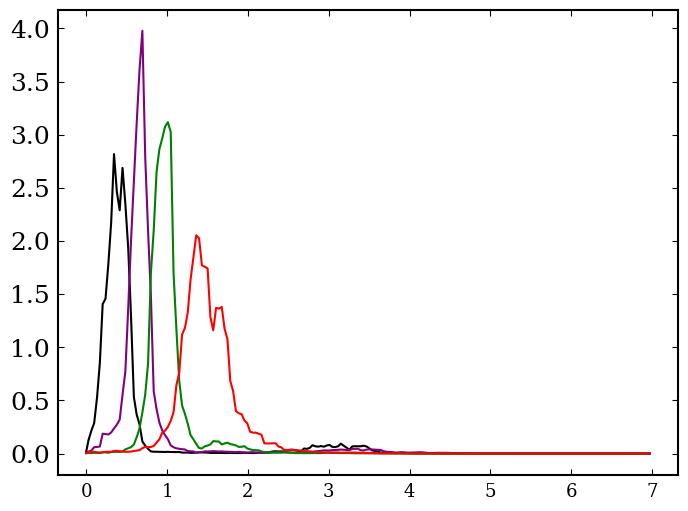

>> multipoles =  [ 149.5  249.5  349.5  499.5  699.5  899.5 1199.5 1599.5 1999.5]
>> Covariance matrix shape BEFORE removing GGL and Shear
(708, 708)
>> Covariance matrix shape AFTER removing GGL and Shear
(36, 36)
>> Length of the signal:  36
>> Introducing covariance matrix


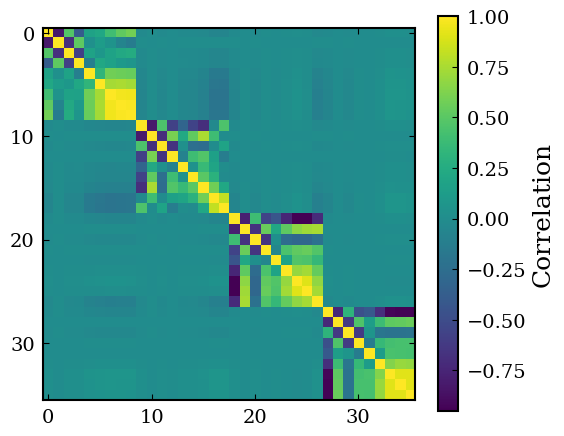

Z-BIN COMBINATION 0 0
z-bin = (0, 0), z_eff = 0.584
Comoving distance = 2228.91 Mpc
Z-BIN COMBINATION 1 0
z-bin = (1, 0), z_eff = 0.679
Comoving distance = 2523.78 Mpc
Z-BIN COMBINATION 1 1
z-bin = (1, 1), z_eff = 0.773
Comoving distance = 2802.08 Mpc
Z-BIN COMBINATION 2 0
z-bin = (2, 0), z_eff = 0.794
Comoving distance = 2860.6 Mpc
Z-BIN COMBINATION 2 1
z-bin = (2, 1), z_eff = 0.889
Comoving distance = 3120.08 Mpc
Z-BIN COMBINATION 2 2
z-bin = (2, 2), z_eff = 1.004
Comoving distance = 3416.82 Mpc
Z-BIN COMBINATION 3 0
z-bin = (3, 0), z_eff = 1.039
Comoving distance = 3503.04 Mpc
Z-BIN COMBINATION 3 1
z-bin = (3, 1), z_eff = 1.134
Comoving distance = 3727.44 Mpc
Z-BIN COMBINATION 3 2
z-bin = (3, 2), z_eff = 1.25
Comoving distance = 3984.77 Mpc
Z-BIN COMBINATION 3 3
z-bin = (3, 3), z_eff = 1.495
Comoving distance = 4479.89 Mpc


In [13]:
s = HSCAnalysisUtils.GenerateHODClustering(cosmo = cosmo,
                                           pk_ggf = pk_ggf,
                                           apply_scalecuts=False)

In [14]:
fname = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/harmonic/hod_clustering/summary_statistics_clustering_hod_rsd.fits'
labels = 'HOD Clustering (Planck 2018 Cosmology)'

##########################################
    Plotting Clustering 2pt functions    
##########################################
>> Number of lens bins:  4
>> Do not show residuals
>> Initializing figure ...
>> Adding individual measurements
>> Plotting  HOD Clustering (Planck 2018 Cosmology)
DV with covariance
No noise to substract
No noise to substract
No noise to substract
No noise to substract
>> No combined measurement added
>>  Galaxy clustering - Nicola et al.


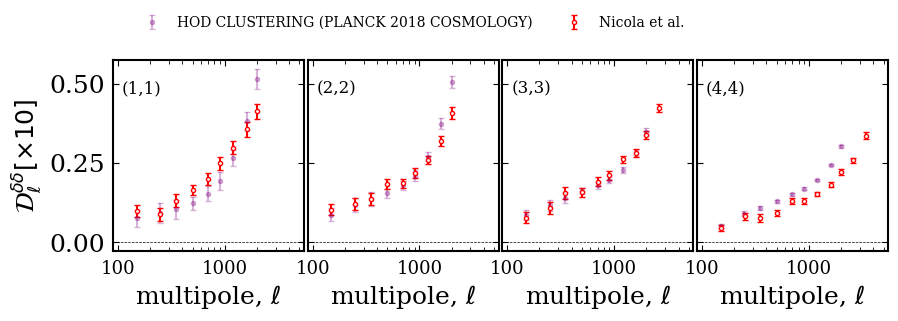

()

In [15]:
hmu.Clustering2pt_plot(fname = [fname],
                        labels = [labels], 
                        add_individual = True,
                        add_combined = False,
                        add_literature = True,
                        save_fig = False)

# Generate dv with scale cuts

In [16]:
# Planck 2018 Cosmology
cosmo = ccl.Cosmology(Omega_c=0.264, Omega_b=0.0493, h=0.6736, sigma8=0.8111, n_s=0.9649)

In [17]:
# Read the full HOD data vector we have just generated above
fname = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/harmonic/hod_clustering/summary_statistics_clustering_hod_rsd.fits'
s = sacc.Sacc.load_fits(fname) 

Generating HOD Clustering Data Vector with scale cuts
Adding lens dndz z-bin 1 ...
Adding lens dndz z-bin 2 ...
Adding lens dndz z-bin 3 ...
Adding lens dndz z-bin 4 ...


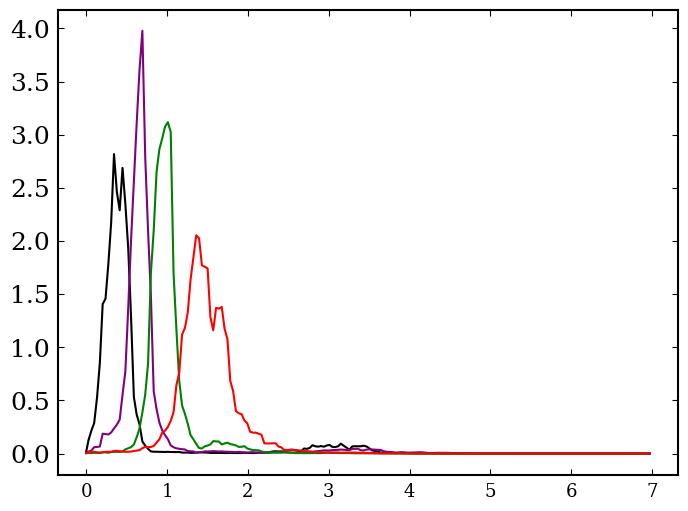

>> multipoles =  [ 149.5  249.5  349.5  499.5  699.5  899.5 1199.5 1599.5 1999.5]
>> Covariance matrix shape BEFORE removing GGL and Shear
(708, 708)
>> Covariance matrix shape AFTER removing GGL and Shear
(36, 36)
>> Length of the signal:  36
>> Introducing covariance matrix


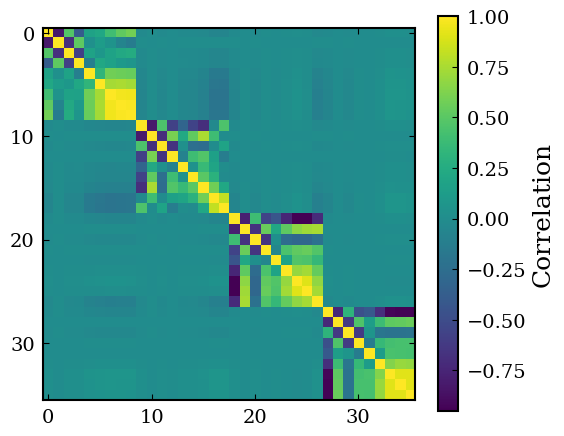

Z-BIN COMBINATION 0 0
z-bin = (0, 0), z_eff = 0.584
Comoving distance = 2228.91 Mpc
Z-BIN COMBINATION 1 0
z-bin = (1, 0), z_eff = 0.679
Comoving distance = 2523.78 Mpc
Z-BIN COMBINATION 1 1
z-bin = (1, 1), z_eff = 0.773
Comoving distance = 2802.08 Mpc
Z-BIN COMBINATION 2 0
z-bin = (2, 0), z_eff = 0.794
Comoving distance = 2860.6 Mpc
Z-BIN COMBINATION 2 1
z-bin = (2, 1), z_eff = 0.889
Comoving distance = 3120.08 Mpc
Z-BIN COMBINATION 2 2
z-bin = (2, 2), z_eff = 1.004
Comoving distance = 3416.82 Mpc
Z-BIN COMBINATION 3 0
z-bin = (3, 0), z_eff = 1.039
Comoving distance = 3503.04 Mpc
Z-BIN COMBINATION 3 1
z-bin = (3, 1), z_eff = 1.134
Comoving distance = 3727.44 Mpc
Z-BIN COMBINATION 3 2
z-bin = (3, 2), z_eff = 1.25
Comoving distance = 3984.77 Mpc
Z-BIN COMBINATION 3 3
z-bin = (3, 3), z_eff = 1.495
Comoving distance = 4479.89 Mpc
>> Producing DATA VECTORS with scale cuts
#######################
k_max = 1.5 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 3343
Correlation =  1 0

/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-

#######################
k_max = 0.3 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 668
Correlation =  1 0
ell_max = 757
Correlation =  1 1
ell_max = 840
Correlation =  2 0
ell_max = 858
Correlation =  2 1
ell_max = 936
Correlation =  2 2
ell_max = 1025
Correlation =  3 0
ell_max = 1050
Correlation =  3 1
ell_max = 1118
Correlation =  3 2
ell_max = 1195
Correlation =  3 3
ell_max = 1343
Number of remaining data points:
Corr 00 = 4
Corr 10 = 0
Corr 11 = 5
Corr 20 = 0
Corr 21 = 0
Corr 22 = 6
Corr 30 = 0
Corr 31 = 0
Corr 32 = 0
Corr 33 = 7
>> Saving data vector ...
#######################
k_max = 0.25 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 557
Correlation =  1 0
ell_max = 630
Correlation =  1 1
ell_max = 700
Correlation =  2 0
ell_max = 715
Correlation =  2 1
ell_max = 780
Correlation =  2 2
ell_max = 854
Correlation =  3 0
ell_max = 875
Correlation =  3 1
ell_max = 931
Correlation =  3 2
ell_max = 996
Correlation =  3 3
ell_max = 1119
Number of remainin

/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-

#######################
k_max = 0.05 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 111
Correlation =  1 0
ell_max = 126
Correlation =  1 1
ell_max = 140
Correlation =  2 0
ell_max = 143
Correlation =  2 1
ell_max = 156
Correlation =  2 2
ell_max = 170
Correlation =  3 0
ell_max = 175
Correlation =  3 1
ell_max = 186
Correlation =  3 2
ell_max = 199
Correlation =  3 3
ell_max = 223
Number of remaining data points:
Corr 00 = 0
Corr 10 = 0
Corr 11 = 0
Corr 20 = 0
Corr 21 = 0
Corr 22 = 1
Corr 30 = 0
Corr 31 = 0
Corr 32 = 0
Corr 33 = 1
>> Saving data vector ...


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


In [18]:
generate = True

if generate == True:
    print('Generating HOD Clustering Data Vector with scale cuts')
    S = HSCAnalysisUtils.GenerateHODClustering(cosmo = cosmo,
                                            pk_ggf = pk_ggf,
                                            apply_scalecuts=True)

# Run minimizers
## Obtain best-fit linear galaxy bias

Calculations, looking for the best-fit using `maxlike` can be found in `/pscratch/sd/d/davidsan/new_firecrown/firecrown/examples/hsc_3x2pt/clustering/scale_cuts`

# Choice of the maximum scale

Considering two different factors:
- Goodness-of-fit, $\chi^2$
- Best-fit linear galaxy bias vs. input linear galaxy bias
we choose up to which scale, the linear galaxy bias is a good description of our galaxy clustering.

In [19]:
zeff_dict, chi_dict = HSCAnalysisUtils.zEffective_Comoving_Dist_Calculation(s = s, cosmo = cosmo)

Z-BIN COMBINATION 0 0
z-bin = (0, 0), z_eff = 0.584
Comoving distance = 2228.91 Mpc
Z-BIN COMBINATION 1 0
z-bin = (1, 0), z_eff = 0.679
Comoving distance = 2523.78 Mpc
Z-BIN COMBINATION 1 1
z-bin = (1, 1), z_eff = 0.773
Comoving distance = 2802.08 Mpc
Z-BIN COMBINATION 2 0
z-bin = (2, 0), z_eff = 0.794
Comoving distance = 2860.6 Mpc
Z-BIN COMBINATION 2 1
z-bin = (2, 1), z_eff = 0.889
Comoving distance = 3120.08 Mpc
Z-BIN COMBINATION 2 2
z-bin = (2, 2), z_eff = 1.004
Comoving distance = 3416.82 Mpc
Z-BIN COMBINATION 3 0
z-bin = (3, 0), z_eff = 1.039
Comoving distance = 3503.04 Mpc
Z-BIN COMBINATION 3 1
z-bin = (3, 1), z_eff = 1.134
Comoving distance = 3727.44 Mpc
Z-BIN COMBINATION 3 2
z-bin = (3, 2), z_eff = 1.25
Comoving distance = 3984.77 Mpc
Z-BIN COMBINATION 3 3
z-bin = (3, 3), z_eff = 1.495
Comoving distance = 4479.89 Mpc


In [20]:
for i in np.arange(4):
    print('zeff bin %d = %.3f'%(i + 1, zeff_dict[f'{i}_{i}']))
    print('chi bin %d = %.3f in Mpc'%(i + 1, chi_dict[f'{i}_{i}']))

zeff bin 1 = 0.584
chi bin 1 = 2228.907 in Mpc
zeff bin 2 = 0.773
chi bin 2 = 2802.077 in Mpc
zeff bin 3 = 1.004
chi bin 3 = 3416.823 in Mpc
zeff bin 4 = 1.495
chi bin 4 = 4479.894 in Mpc


Correlation =  0 0
ell_max = 156
Correlation =  1 0
ell_max = 176
Correlation =  1 1
ell_max = 196
Correlation =  2 0
ell_max = 200
Correlation =  2 1
ell_max = 218
Correlation =  2 2
ell_max = 239
Correlation =  3 0
ell_max = 245
Correlation =  3 1
ell_max = 260
Correlation =  3 2
ell_max = 278
Correlation =  3 3
ell_max = 313
############################################
###      kmax = 0.07 Mpc^-1          ###
############################################
<< Chisq calculation >>


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Removing galaxy clustering cross-correlations
Chisq = 0.02
Chisq / ndof = 0.02
Degrees-of-freedom = 1
Chisq = 0.02
Chisq / ndof = 0.02


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 178
Correlation =  1 0
ell_max = 201
Correlation =  1 1
ell_max = 224
Correlation =  2 0
ell_max = 228
Correlation =  2 1
ell_max = 249
Correlation =  2 2
ell_max = 273
Correlation =  3 0
ell_max = 280
Correlation =  3 1
ell_max = 298
Correlation =  3 2
ell_max = 318
Correlation =  3 3
ell_max = 358
############################################
###      kmax = 0.08 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 0.02
Chisq / ndof = 0.01
Degrees-of-freedom = 3
Chisq = 0.02
Chisq / ndof = 0.01


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 200
Correlation =  1 0
ell_max = 227
Correlation =  1 1
ell_max = 252
Correlation =  2 0
ell_max = 257
Correlation =  2 1
ell_max = 280
Correlation =  2 2
ell_max = 307
Correlation =  3 0
ell_max = 315
Correlation =  3 1
ell_max = 335
Correlation =  3 2
ell_max = 358
Correlation =  3 3
ell_max = 403
############################################
###      kmax = 0.09 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 0.02
Chisq / ndof = 0.01
Degrees-of-freedom = 4
Chisq = 0.02
Chisq / ndof = 0.01


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 222
Correlation =  1 0
ell_max = 252
Correlation =  1 1
ell_max = 280
Correlation =  2 0
ell_max = 286
Correlation =  2 1
ell_max = 312
Correlation =  2 2
ell_max = 341
Correlation =  3 0
ell_max = 350
Correlation =  3 1
ell_max = 372
Correlation =  3 2
ell_max = 398
Correlation =  3 3
ell_max = 447
############################################
###      kmax = 0.1 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 0.02
Chisq / ndof = 0.01
Degrees-of-freedom = 4
Chisq = 0.02
Chisq / ndof = 0.01
Correlation =  0 0
ell_max = 334
Correlation =  1 0
ell_max = 378
Correlation =  1 1
ell_max = 420
Correlation =  2 0
ell_max = 429
Correlation =  2 1
ell_max = 468
Correlation =  2 2
ell_max = 512
Correlation =  3 0
ell_max = 525
Correlation =  3 1
ell_max = 559
Correlation =  3 2
ell_max = 597
Correlation =  3 3
ell_max = 671
############################################
###   

/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Removing galaxy clustering cross-correlations
Chisq = 0.38
Chisq / ndof = 0.04
Degrees-of-freedom = 9
Chisq = 0.38
Chisq / ndof = 0.04


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 445
Correlation =  1 0
ell_max = 504
Correlation =  1 1
ell_max = 560
Correlation =  2 0
ell_max = 572
Correlation =  2 1
ell_max = 624
Correlation =  2 2
ell_max = 683
Correlation =  3 0
ell_max = 700
Correlation =  3 1
ell_max = 745
Correlation =  3 2
ell_max = 796
Correlation =  3 3
ell_max = 895
############################################
###      kmax = 0.2 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 1.29
Chisq / ndof = 0.11
Degrees-of-freedom = 12
Chisq = 1.29
Chisq / ndof = 0.11


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 557
Correlation =  1 0
ell_max = 630
Correlation =  1 1
ell_max = 700
Correlation =  2 0
ell_max = 715
Correlation =  2 1
ell_max = 780
Correlation =  2 2
ell_max = 854
Correlation =  3 0
ell_max = 875
Correlation =  3 1
ell_max = 931
Correlation =  3 2
ell_max = 996
Correlation =  3 3
ell_max = 1119
############################################
###      kmax = 0.25 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 5.0
Chisq / ndof = 0.31
Degrees-of-freedom = 16
Chisq = 5.0
Chisq / ndof = 0.31
Correlation =  0 0
ell_max = 668
Correlation =  1 0
ell_max = 757
Correlation =  1 1
ell_max = 840
Correlation =  2 0
ell_max = 858
Correlation =  2 1
ell_max = 936
Correlation =  2 2
ell_max = 1025
Correlation =  3 0
ell_max = 1050
Correlation =  3 1
ell_max = 1118
Correlation =  3 2
ell_max = 1195
Correlation =  3 3
ell_max = 1343
############################################


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Removing galaxy clustering cross-correlations
Chisq = 12.27
Chisq / ndof = 0.68
Degrees-of-freedom = 18
Chisq = 12.27
Chisq / ndof = 0.68


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 891
Correlation =  1 0
ell_max = 1009
Correlation =  1 1
ell_max = 1120
Correlation =  2 0
ell_max = 1144
Correlation =  2 1
ell_max = 1248
Correlation =  2 2
ell_max = 1366
Correlation =  3 0
ell_max = 1401
Correlation =  3 1
ell_max = 1490
Correlation =  3 2
ell_max = 1593
Correlation =  3 3
ell_max = 1791
############################################
###      kmax = 0.4 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 43.86
Chisq / ndof = 1.99
Degrees-of-freedom = 22
Chisq = 43.86
Chisq / ndof = 1.99


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 1114
Correlation =  1 0
ell_max = 1261
Correlation =  1 1
ell_max = 1401
Correlation =  2 0
ell_max = 1430
Correlation =  2 1
ell_max = 1560
Correlation =  2 2
ell_max = 1708
Correlation =  3 0
ell_max = 1751
Correlation =  3 1
ell_max = 1863
Correlation =  3 2
ell_max = 1992
Correlation =  3 3
ell_max = 2239
############################################
###      kmax = 0.5 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 120.75
Chisq / ndof = 4.64
Degrees-of-freedom = 26
Chisq = 120.75
Chisq / ndof = 4.64


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 1337
Correlation =  1 0
ell_max = 1514
Correlation =  1 1
ell_max = 1681
Correlation =  2 0
ell_max = 1716
Correlation =  2 1
ell_max = 1872
Correlation =  2 2
ell_max = 2050
Correlation =  3 0
ell_max = 2101
Correlation =  3 1
ell_max = 2236
Correlation =  3 2
ell_max = 2390
Correlation =  3 3
ell_max = 2687
############################################
###      kmax = 0.6 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 121.53
Chisq / ndof = 4.19
Degrees-of-freedom = 29
Chisq = 121.53
Chisq / ndof = 4.19


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 1560
Correlation =  1 0
ell_max = 1766
Correlation =  1 1
ell_max = 1961
Correlation =  2 0
ell_max = 2002
Correlation =  2 1
ell_max = 2184
Correlation =  2 2
ell_max = 2391
Correlation =  3 0
ell_max = 2452
Correlation =  3 1
ell_max = 2609
Correlation =  3 2
ell_max = 2789
Correlation =  3 3
ell_max = 3135
############################################
###      kmax = 0.7 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 121.53
Chisq / ndof = 4.19
Degrees-of-freedom = 29
Chisq = 121.53
Chisq / ndof = 4.19


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 1783
Correlation =  1 0
ell_max = 2019
Correlation =  1 1
ell_max = 2241
Correlation =  2 0
ell_max = 2288
Correlation =  2 1
ell_max = 2496
Correlation =  2 2
ell_max = 2733
Correlation =  3 0
ell_max = 2802
Correlation =  3 1
ell_max = 2981
Correlation =  3 2
ell_max = 3187
Correlation =  3 3
ell_max = 3583
############################################
###      kmax = 0.8 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 135.83
Chisq / ndof = 4.38
Degrees-of-freedom = 31
Chisq = 135.83
Chisq / ndof = 4.38


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 2006
Correlation =  1 0
ell_max = 2271
Correlation =  1 1
ell_max = 2521
Correlation =  2 0
ell_max = 2574
Correlation =  2 1
ell_max = 2808
Correlation =  2 2
ell_max = 3075
Correlation =  3 0
ell_max = 3152
Correlation =  3 1
ell_max = 3354
Correlation =  3 2
ell_max = 3586
Correlation =  3 3
ell_max = 4031
############################################
###      kmax = 0.9 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 151.84
Chisq / ndof = 4.75
Degrees-of-freedom = 32
Chisq = 151.84
Chisq / ndof = 4.75


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 2228
Correlation =  1 0
ell_max = 2523
Correlation =  1 1
ell_max = 2802
Correlation =  2 0
ell_max = 2860
Correlation =  2 1
ell_max = 3120
Correlation =  2 2
ell_max = 3416
Correlation =  3 0
ell_max = 3503
Correlation =  3 1
ell_max = 3727
Correlation =  3 2
ell_max = 3984
Correlation =  3 3
ell_max = 4479
############################################
###      kmax = 1.0 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 151.84
Chisq / ndof = 4.75
Degrees-of-freedom = 32
Chisq = 151.84
Chisq / ndof = 4.75


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation =  0 0
ell_max = 3343
Correlation =  1 0
ell_max = 3785
Correlation =  1 1
ell_max = 4203
Correlation =  2 0
ell_max = 4290
Correlation =  2 1
ell_max = 4680
Correlation =  2 2
ell_max = 5125
Correlation =  3 0
ell_max = 5254
Correlation =  3 1
ell_max = 5591
Correlation =  3 2
ell_max = 5977
Correlation =  3 3
ell_max = 6719
############################################
###      kmax = 1.5 Mpc^-1          ###
############################################
<< Chisq calculation >>
Removing galaxy clustering cross-correlations
Chisq = 151.84
Chisq / ndof = 4.75
Degrees-of-freedom = 32
Chisq = 151.84
Chisq / ndof = 4.75


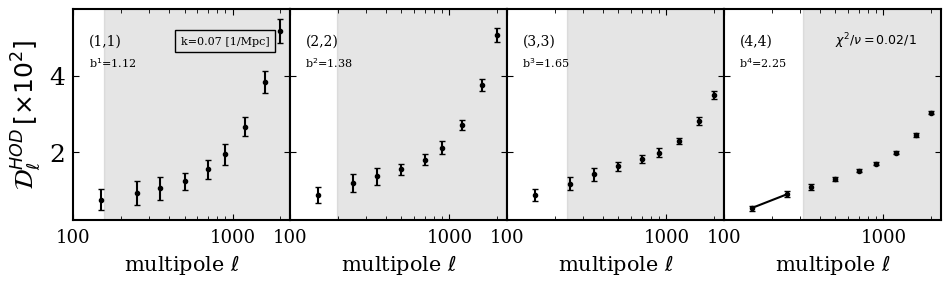

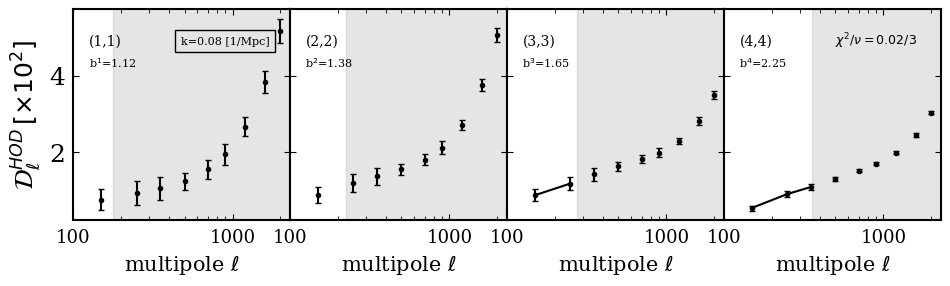

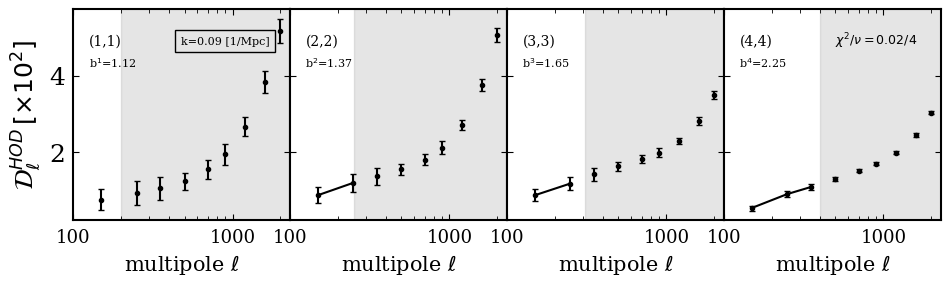

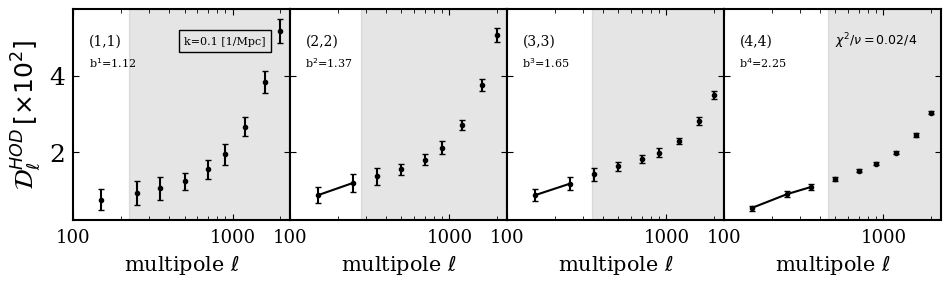

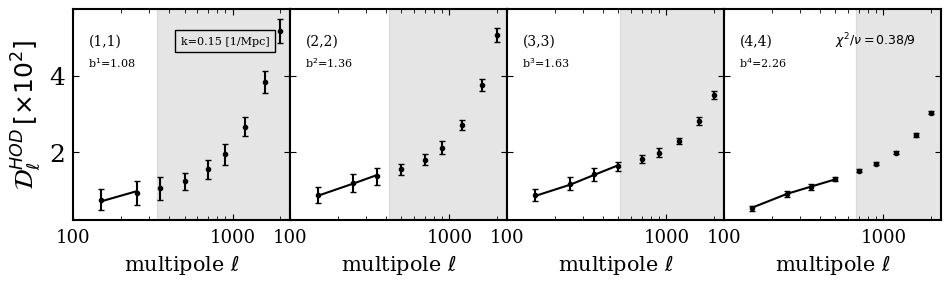

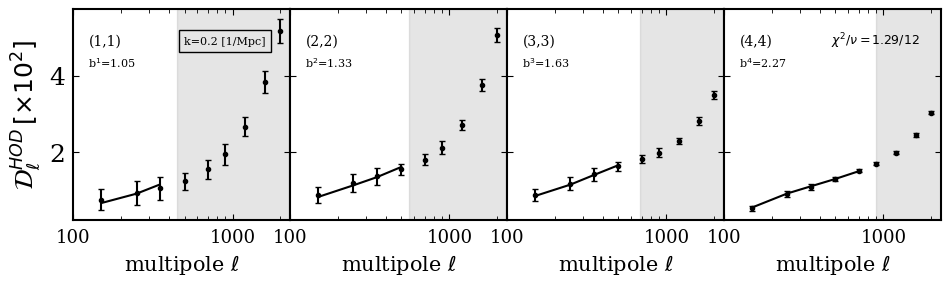

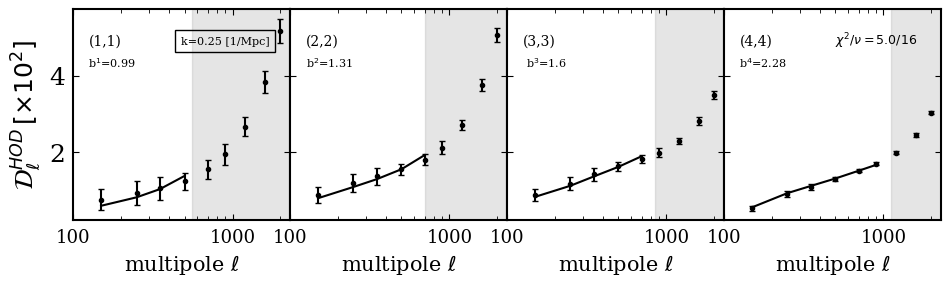

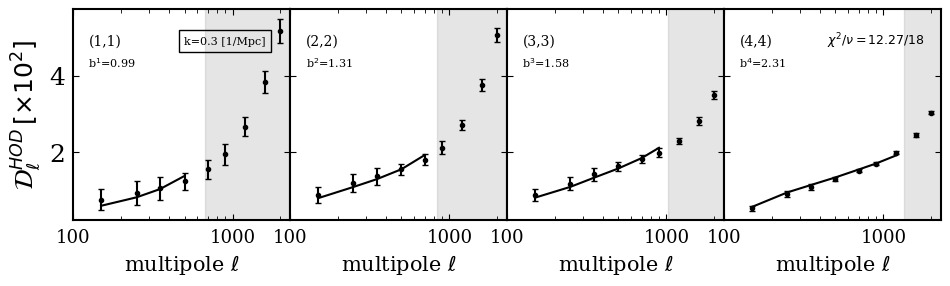

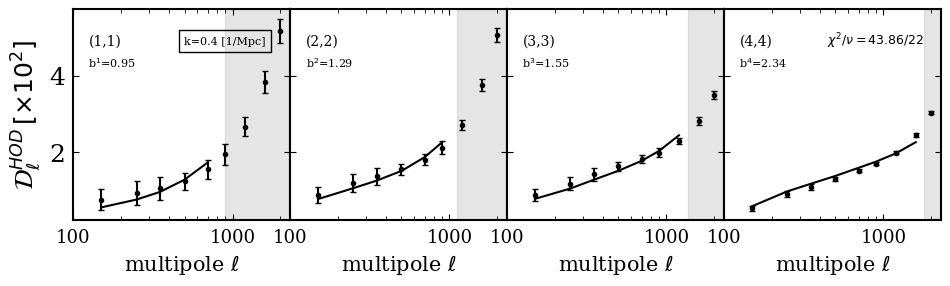

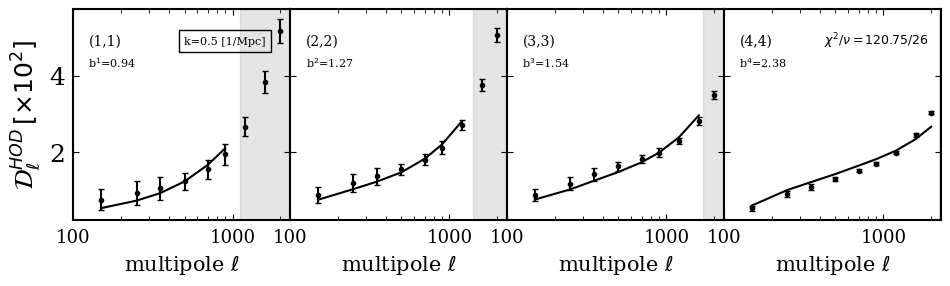

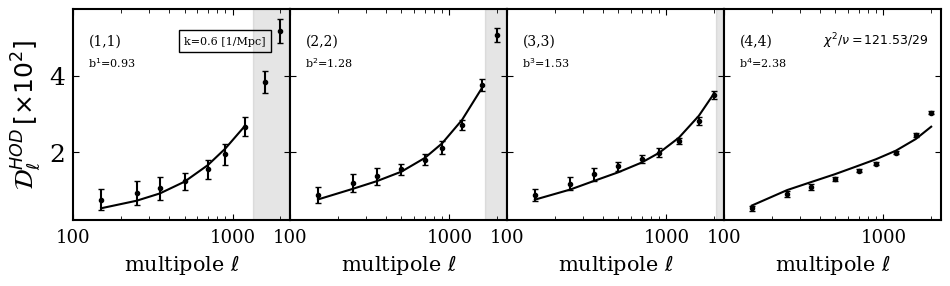

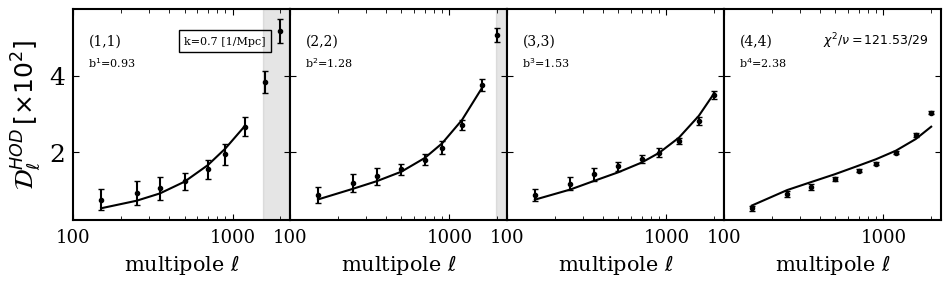

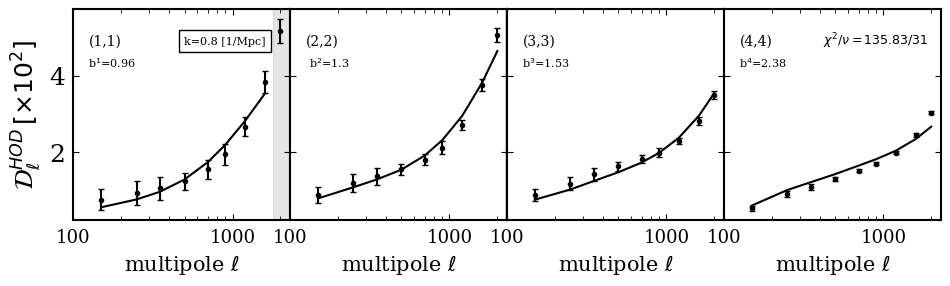

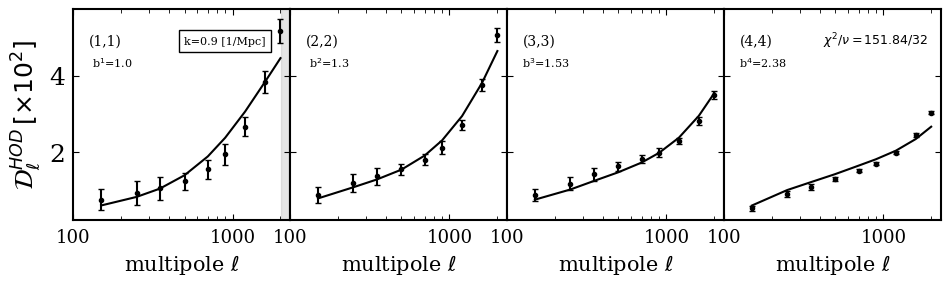

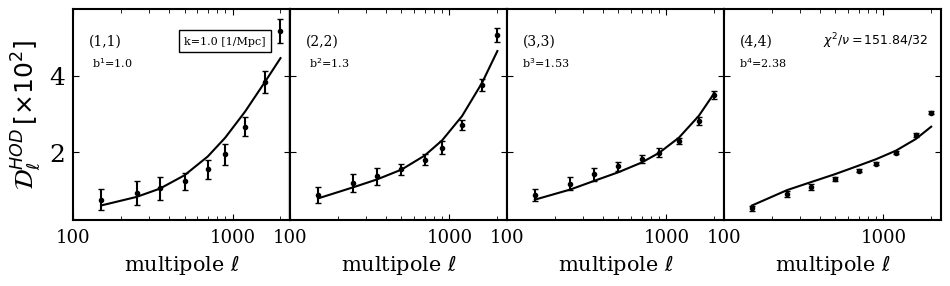

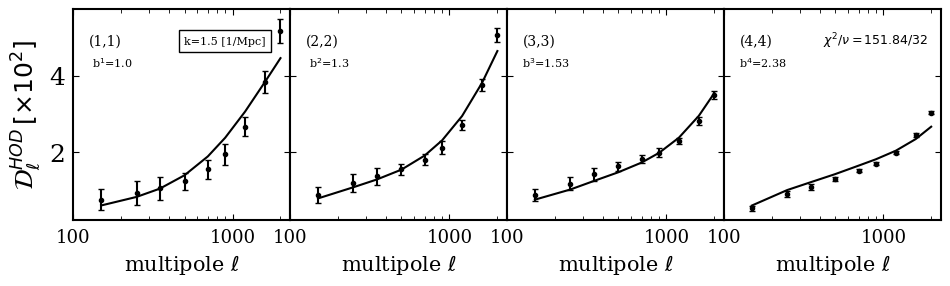

In [21]:
path_to_save = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/figures/measurements/clustering/scale_cuts'

# Data vectors with [0.05, 0.06] have no remaining data points after scale cuts
kmax_array = np.array([0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5])

# Initialize an empty dictionary where to save bias values with k_max as key
scale_cut_bias_dict = dict()

# Initialize where to read information
path_dv = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/harmonic/hod_clustering'
# Extract best-fit linear galaxy bias for each k_max case
path_bestfit = '/pscratch/sd/d/davidsan/new_firecrown/firecrown/examples/hsc_3x2pt/clustering/scale_cuts/output'

# Let's read the whole HOD mock signal just for plotting
fname_plot = os.path.join(path_dv, f'summary_statistics_clustering_hod_rsd.fits')
s_plot = sacc.Sacc.load_fits(fname_plot)

g = open('chisq_info_rsd.txt','w')
g.write('** Analysing the goodness-of-fit of linear galaxy bias with HOD data to design clustering scale cuts ** \n')
for k_max in kmax_array:
    g.write('\n')
    g.write(f'kmax = {k_max} \n')
    g.write('\n')
    # Read HOD mock signal
    sacc_fname = os.path.join(path_dv, f'summary_statistics_clustering_hod_rsd_kmax_{k_max}.sacc')
    # Read HOD best-fit prediction
    theory_fname = os.path.join(path_bestfit, f'output_clustering_GC_k_{k_max}/best-fit/data_vector')
    fname_bestfit = os.path.join(path_bestfit, f'output_clustering_GC_k_{k_max}/best-fit/firecrown_two_point/values.txt')
    # Read fname_bestfit txt file
    f = open(fname_bestfit, 'r')
    lines = f.readlines()
    # Initialize bias variable
    lbias_arr = np.array([])
    for line in lines:
        if 'bias' in line:
            # Extract the number from the string
            bias = float(line.split(' ')[-1])
            lbias_arr = np.append(lbias_arr, bias)
    f.close()
    # Save in the dictionary lbias_arr with k_max as key
    scale_cut_bias_dict[k_max] = lbias_arr
    # print(lbias_arr)    
    # Compute the maximum multipole for each z-bin pair
    l_max = HSCAnalysisUtils.Kmax_to_Ellmax(kmax = k_max, chi_dict = chi_dict)
    # print(l_max)
    
    print('############################################')
    print(f'###      kmax = {k_max} Mpc^-1          ###')
    print('############################################')
    
    nbins_lens = 4
    fig, axs = plt.subplots(1, nbins_lens, sharex=True, sharey='row', figsize=(10,3))
    fig.tight_layout()

    plt.subplots_adjust(wspace=0, hspace=0)

    for i in np.arange(nbins_lens):

        # To Plot all data points
        ell_plot, Cell_plot, cov_plot = s_plot.get_ell_cl('galaxy_density_cl', f'lens_{i}', f'lens_{i}', return_cov=True)
        err_plot = np.sqrt(np.diag(cov_plot))
        # Compute the prefactor
        pref = ell_plot * (ell_plot + 1) / (2 * np.pi) * 10 ** 2
        # Apply the prefactor
        Cell_plot = Cell_plot * pref
        err_plot = err_plot * pref
        axs[i].errorbar(ell_plot, Cell_plot, yerr=err_plot,
                        color=colors[0], 
                        fmt='o', 
                        markersize=3.0, 
                        capsize=2)

        # To plot the best-fit theory prediction
        ell_bf = np.loadtxt(os.path.join(theory_fname, f'ell_or_theta_galaxy_density_cl_lens_{i}_lens_{i}.txt'))
        Cell_bf = np.loadtxt(os.path.join(theory_fname, f'theory_galaxy_density_cl_lens_{i}_lens_{i}.txt'))
        # Compute the prefactor
        pref = ell_bf * (ell_bf + 1) / (2 * np.pi) * 10 ** 2
        # Apply the prefactor
        Cell_bf = Cell_bf * pref
        axs[i].plot(ell_bf, Cell_bf, color=colors[0], lw=1.5)


        # print(len(Cell_meas))
        axs[i].set_xscale('log')
        # axs[i].loglog()
        axs[i].set_xticks([1e2,1e3],['100','1000'])
        # Plot the scale cuts
        axs[i].axvspan(l_max[f'{i}_{i}'], 2300, alpha=0.2, color='grey')
        axs[i].set_xlim(100, 2300)

        # z-bin pair
        axs[i].text(0.15, 0.85,f'({i+1},{i+1})', ha='center', va='center', transform=axs[i].transAxes, fontsize=10)
        axs[i].text(0.18, 0.75,f'b$^{i+1}$={np.round(lbias_arr[i], 2)}', ha='center', va='center', transform=axs[i].transAxes, fontsize=8)

        if i == 0:
            axs[i].set_ylabel('$\mathcal{D}^{HOD}_\ell \, [\\times 10^2]$', fontsize=18)

        axs[i].set_xlabel('multipole $\ell$', fontsize=15)

    ###################
    # Goodness-of-fit #
    ###################
    probe = 'galaxy_density_cl'
    npar = 4 # minimizing to obtain linear galaxy bias parameters
    chisq, chisq_ndof, ndof = hmu.ComputeChisq(sacc_fname = sacc_fname, 
                                                theory_fname = theory_fname, 
                                                probe = probe, 
                                                npar = npar)

    print(f'Degrees-of-freedom = {ndof}')
    g.write(f'Degrees-of-freedom = {ndof} \n')
    print(f'Chisq = {np.round(chisq, 2)}')
    g.write(f'Chisq = {np.round(chisq, 2)} \n')
    print(f'Chisq / ndof = {np.round(chisq_ndof, 2)}') 
    g.write(f'Chisq / ndof = {np.round(chisq_ndof, 2)} \n')   
    g.write('\n')
 
    axs[3].text(0.7, 0.85, f'$\\chi^2 / \\nu = {np.around(chisq, 2)}/{ndof}$', ha='center', va='center', transform=axs[3].transAxes, fontsize=9)

    axs[3].legend(loc='upper left', fontsize=6, frameon=False)
    
    kmax_str=f'k={k_max} [1/Mpc]'
    axs[0].text(0.7, 0.85, kmax_str, ha='center', va='center', transform=axs[0].transAxes, fontsize=8, bbox=dict(edgecolor='black', facecolor='none'))

    plt.savefig(os.path.join(path_to_save, f'sc_rsd_k_max_{k_max}.png'),
               dpi=300,
               bbox_inches='tight')
    
    plt.savefig(os.path.join(path_to_save, f'sc_rsd_k_max_{k_max}.pdf'),
               dpi=300,
               bbox_inches='tight') 
plt.show
f.close() 

# Halo bias: computing linear galaxy bias coefficients

Calculation taken from the original notebook `/pscratch/sd/d/davidsan/3x2pt-HSC/HSC-3x2pt-methods/scale_cuts/hod_clustering_scale_cuts/Halo_Bias.ipynb`

In [22]:
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm
from scipy.special import erf
%matplotlib inline
import os 
import sacc
import datetime
import time
from scipy.integrate import simps

In [23]:
# Planck 2018 Cosmology
cosmo = ccl.Cosmology(Omega_c=0.264, Omega_b=0.0493, h=0.6736, sigma8=0.8111, n_s=0.9649)

# Wavenumbers and scale factors
k_arr = np.geomspace(1E-4,1E1,256)
a_arr = np.linspace(0.1,1,64)

In [24]:
# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()

# The Duffy 2008 concentration-mass relation (Checked - used in paper)
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# The Tinker 2008 mass function (Checked - used in paper)
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200m)

# # The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

In [25]:
class HaloProfileHOD(ccl.halos.HaloProfileNFW):
    def __init__(self, c_M_relation,
                 lMmin=12.02, lMminp=-1.34,
                 lM0=6.6, lM0p=-1.43,
                 lM1=13.27, lM1p=-0.323):
        self.lMmin=lMmin
        self.lMminp=lMminp
        self.lM0=lM0
        self.lM0p=lM0p
        self.lM1=lM1
        self.lM1p=lM1p
        # Pivot is z_p = 0.65
        self.a0 = 1./(1+0.65)
        self.sigmaLogM = 0.4
        self.alpha = 1.
        super(HaloProfileHOD, self).__init__(c_M_relation)
        self._fourier = self._fourier_analytic_hod

    def _lMmin(self, a):
        return self.lMmin + self.lMminp * (a - self.a0)

    def _lM0(self, a):
        return self.lM0 + self.lM0p * (a - self.a0)

    def _lM1(self, a):
        return self.lM1 + self.lM1p * (a - self.a0)

    def _Nc(self, M, a):
        # Number of centrals
        Mmin = 10.**self._lMmin(a)
        return 0.5 * (1 + erf(np.log(M / Mmin) / self.sigmaLogM))

    def _Ns(self, M, a):
        # Number of satellites
        M0 = 10.**self._lM0(a)
        M1 = 10.**self._lM1(a)
        return np.heaviside(M-M0,1) * ((M - M0) / M1)**self.alpha

    def _fourier_analytic_hod(self, cosmo, k, M, a, mass_def):
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)

        Nc = self._Nc(M_use, a)
        Ns = self._Ns(M_use, a)
        # NFW profile
        uk = self._fourier_analytic(cosmo, k_use, M_use, a, mass_def) / M_use[:, None]

        prof = Nc[:, None] * (1 + Ns[:, None] * uk)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

    def _fourier_variance(self, cosmo, k, M, a, mass_def):
        # Fourier-space variance of the HOD profile
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)

        Nc = self._Nc(M_use, a)
        Ns = self._Ns(M_use, a)
        # NFW profile
        uk = self._fourier_analytic(cosmo, k_use, M_use, a, mass_def) / M_use[:, None]

        prof = Ns[:, None] * uk
        prof = Nc[:, None] * (2 * prof + prof**2)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

pg = HaloProfileHOD(cM)

In [26]:
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m)

In [27]:
class Profile2ptHOD(ccl.halos.Profile2pt):
    def fourier_2pt(self, prof, cosmo, k, M, a,
                      prof2=None, mass_def=None):
        return prof._fourier_variance(cosmo, k, M ,a, mass_def)
HOD2pt = Profile2ptHOD()
    
pk_gg = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1.,
                                         pg, prof_2pt=HOD2pt,
                                         normprof1=True)

In [28]:
# Initialize an empty array to store the effective redshift values
zeff = np.array([])

# Iterate over the range of 4
for i in np.arange(4):
    # Append the effective redshift value for each z-bin pair to the 'zeff' array
    zeff = np.append(zeff, zeff_dict[f'{i}_{i}'])

In [29]:
for i in np.arange(4):
    print('Effective redshift for bin %d = %.3f'%(i + 1, zeff[i]))

Effective redshift for bin 1 = 0.584
Effective redshift for bin 2 = 0.773
Effective redshift for bin 3 = 1.004
Effective redshift for bin 4 = 1.495


In [30]:
def halo_mass(z, ind):
    # ind can be 'min', '0' or '1'
    z_piv = 0.65
    
    if ind == 'min':
        # best fit values from Andrina's paper
        mu = 12.02
        mup = -1.34
        
    elif ind == '0':
        mu = 6.6
        mup = -1.43
        
    elif ind == '1':
        mu = 13.27
        mup = -0.323
        
    logM = mu + mup * (1 / (1 + z) - 1 / (1 + z_piv))
    M = 10 ** logM
    
    return(M)

In [31]:
for z in zeff:
    print('*****************************************************')
    print(f'Computing linear galaxy bias at z = {np.round(z,2)}')
    print('*****************************************************')
    M0 = halo_mass(z=z, ind='0')
    print(f'Minimal galaxy mass M0 = 10^({np.round(np.log10(M0),2)})')
    m_arr =  np.logspace(np.log10(M0),17,128)
    # Compute the mass function
    distr_M = nM.get_mass_function(cosmo=cosmo,M=m_arr,a=1/(1+z))
    #Compute the number of centrals and satellites
    Nc = pg._Nc(M=m_arr, a=1/(1+z))
    Ns = pg._Ns(M=m_arr, a=1/(1+z))
    # Compute the mean number density of galaxies
    integrando = distr_M * Nc * (1 + Ns)
    ngal = simps(integrando, x=np.log10(m_arr))
    print(f'ngal = {np.round(ngal, 5)}')
    # Compute the halo bias
    halo_bias = bM.get_halo_bias(cosmo=cosmo, M=m_arr, a=1/(1+z))
    integrando = distr_M * halo_bias * Nc * (1 + Ns)
    integral = simps(integrando, x=np.log10(m_arr))
    
    gal_lbias = integral / ngal
    print(f'gbias = {np.round(gal_lbias, 2)}')
    print(gal_lbias)  

*****************************************************
Computing linear galaxy bias at z = 0.58
*****************************************************
Minimal galaxy mass M0 = 10^(6.56)
ngal = 0.00254
gbias = 1.31
1.3132354253451917
*****************************************************
Computing linear galaxy bias at z = 0.77
*****************************************************
Minimal galaxy mass M0 = 10^(6.66)
ngal = 0.00197
gbias = 1.48
1.4786206734880059
*****************************************************
Computing linear galaxy bias at z = 1.0
*****************************************************
Minimal galaxy mass M0 = 10^(6.75)
ngal = 0.00146
gbias = 1.71
1.7089655279482314
*****************************************************
Computing linear galaxy bias at z = 1.49
*****************************************************
Minimal galaxy mass M0 = 10^(6.89)
ngal = 0.00076
gbias = 2.31
2.3121410614338616


## Consistency plot

Compare input galaxy bias in mocks, computed above, wrt to bias coefficients obtained from minimizers.

Calculation taken from `/pscratch/sd/d/davidsan/3x2pt-HSC/HSC-3x2pt-methods/GalaxyClustering/bias_lens_consistency/bias_consistency_check_withRSD.ipynb`

In [32]:
# Bias obtained in previous section (see output in cell above)
gal_lbias = [1.3132354253451917, 1.4786206734880059, 1.7089655279482314, 2.3121410614338616]
np.round(gal_lbias,2)

array([1.31, 1.48, 1.71, 2.31])

In [33]:
# Dictionary collecting:
# - k_max values as keys
# - linear galaxy bias values as values
scale_cut_bias_dict

{0.07: array([1.11704954, 1.37922209, 1.64850591, 2.25111496]),
 0.08: array([1.11704955, 1.37922211, 1.64580713, 2.25426488]),
 0.09: array([1.11704923, 1.3723461 , 1.64580721, 2.25426489]),
 0.1: array([1.11704923, 1.3723461 , 1.64580721, 2.25426489]),
 0.15: array([1.08232173, 1.36097043, 1.62554035, 2.26398926]),
 0.2: array([1.0466515 , 1.33389912, 1.62554049, 2.27335172]),
 0.25: array([0.98989687, 1.30806128, 1.6039429 , 2.28332021]),
 0.3: array([0.98989688, 1.30806103, 1.58324887, 2.30745913]),
 0.4: array([0.95394017, 1.2893958 , 1.55207144, 2.34085322]),
 0.5: array([0.93646839, 1.27422309, 1.53543585, 2.38273151]),
 0.6: array([0.93422065, 1.28136156, 1.53243237, 2.38273152]),
 0.7: array([0.93422065, 1.28136156, 1.53243237, 2.38273152]),
 0.8: array([0.95615137, 1.30375693, 1.53243184, 2.38273152]),
 0.9: array([0.99634732, 1.30374992, 1.53243184, 2.38273152]),
 1.0: array([0.99634732, 1.30374992, 1.53243184, 2.38273152]),
 1.5: array([0.99634732, 1.30374992, 1.53243184, 2

2


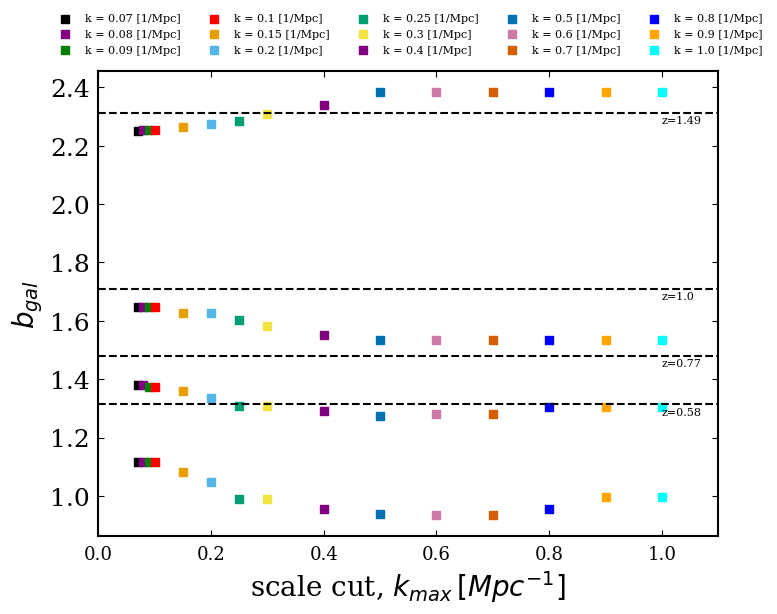

In [39]:
from matplotlib.colors import ListedColormap

cind = 0

f=open('galbias_criteria_rsd.txt','w')
f.write('Distance between the theoretical linear galaxy bias and the one obtained \n')
f.write('with the minimizer defined as the sqrt of the quadratic sum \n')

# Data vectors with [0.05, 0.06] have no remaining data points after scale cuts
kmax_array = np.array([0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) #, 1.5])

# Create a colormap with a unique color for each x value
unique_x_values = np.unique(kmax_array)
num_unique_x = len(unique_x_values)
cmap = plt.get_cmap('tab10', num_unique_x)  # 'tab10' is just an example, you can choose another colormap

for k_max in kmax_array:
    bias = scale_cut_bias_dict[k_max]
    
    # Define a distance between theoretical values and the ones obtained with the minimizer
    dist = np.sqrt(sum(el*el for el in np.array(bias) - np.array(gal_lbias)))
    f.write(f'kmax = {k_max} Mpc^-1 -> dist(th,pred) = {np.round(dist,2)}\n')
    # print(dist)

    for i in np.arange(4):
        if i == 0:
            plt.scatter(k_max, bias[i], c=k_max, marker='s', label=f'k = {k_max} [1/Mpc]')
        else:
            plt.scatter(k_max, bias[i], color=colors[cind], marker='s')
            
    cind += 1

    
f.write('\n')
# for i in np.arange(4):
#     plt.axhline(b_theo[i], xmin=0.0, xmax=1.6, ls='--', color='k')
#     plt.axhspan(b_theo[i]-b_theo_err[i]**2, b_theo[i]+b_theo_err[i]**2, color='grey', alpha=0.3)
    
for i in np.arange(4):
    plt.axhline(gal_lbias[i], xmin=0.0, xmax=1.1, ls='--', color='k')
    plt.text(1.0, gal_lbias[i]-0.035, f'z={np.round(zeff[i],2)}',fontsize=8)
    f.write(f'z-bin {i+1} = {np.round(gal_lbias[i],2)} \n')
    
f.close()
print('2')
# plt.xticks(kmax_array, kmax_array, fontsize=16)
plt.xlim([0.0,1.1])
plt.xlabel('scale cut, $k_{max}\, [Mpc^{-1}]$',fontsize=20)
plt.ylabel('$b_{gal}$',fontsize=20)
#plt.ylabel('linear galaxy bias, $b_{gal}$')
plt.legend(bbox_to_anchor=(0.5,1.08),loc='center',ncol=5, frameon=False, fontsize=8) 

""" plt.savefig(os.path.join('bias_lenses_scale_cuts_rsd.png'),
            format='png',
            dpi=300,
            bbox_inches='tight')

plt.savefig(os.path.join('bias_lenses_scale_cuts_rsd.pdf'),
            dpi=300,
            bbox_inches='tight')  """

plt.show()
plt.close()

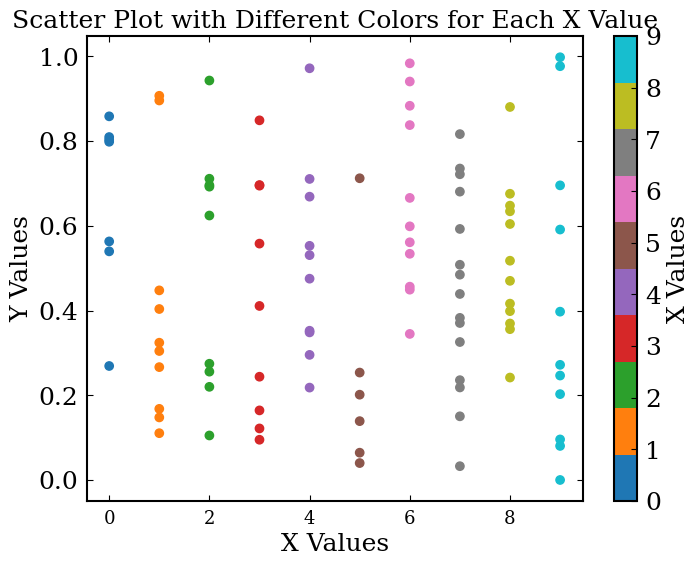

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Generate example data
np.random.seed(42)
num_points = 100
x_values = np.random.randint(0, 10, size=num_points)
y_values = np.random.rand(num_points)

# Create a colormap with a unique color for each x value
unique_x_values = np.unique(x_values)
num_unique_x = len(unique_x_values)
cmap = plt.get_cmap('tab10', num_unique_x)  # 'tab10' is just an example, you can choose another colormap

# Plot the scatter plot
scatter = plt.scatter(x_values, y_values, c=x_values, cmap=cmap, marker='o')

# Add colorbar
cbar = plt.colorbar(scatter, ticks=unique_x_values)
cbar.set_label('X Values')

# Customize the plot
plt.title('Scatter Plot with Different Colors for Each X Value')
plt.xlabel('X Values')
plt.ylabel('Y Values')

# Show the plot
plt.show()
